# Results

In [7]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
import asizeof
import metrics
import kfold
import time
import pickle

m1_emv,t1_emv = pickle.load(open('solar_emvfts_m1t1.pickle','rb'))
m1_mf,t1_mf = pickle.load(open('solar_mondrian_m1t1.pickle','rb'))
m1_osr,t1_osr = pickle.load(open('solar_osrelm_m1t1.pickle','rb'))
m1_sgdr,t1_sgdr = pickle.load(open('solar_sgdr_m1t1.pickle','rb'))
m1_par,t1_par = pickle.load(open('solar_par_m1t1.pickle','rb'))

# forecasts_mondrian_runs = forecasts_mondrian_runs*10
# tempo_mondrian_runs = tempo_mondrian_runs*10
# memoria_mondrian_runs = memoria_mondrian_runs*10
                                                                     
# print(a,b,c,d)

# len(forecasts_mondrian_runs)

m1_mf = m1_mf[1:]


# Dataset

In [8]:
def getRollingWindow(index):
    pivot = index
    train_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=20)
    train_end = pivot.strftime('%Y-%m-%d')

    pivot = pivot + datetime.timedelta(days=1)
    validation_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=6)
    validation_end = pivot.strftime('%Y-%m-%d')

    pivot = pivot + datetime.timedelta(days=1)
    test_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=6)
    test_end = pivot.strftime('%Y-%m-%d')
    
    return train_start, train_end, validation_start, validation_end, test_start, test_end

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

#df = pd.read_csv('https://query.data.world/s/wo5wryokqyg5uvbfqqij2mucgwly5u',  parse_dates=['datetime'], index_col=0)
df = pd.read_csv('solar_oahu_df.csv',  parse_dates=['datetime'], index_col=0)

df = normalize(df)

# Split data
interval = ((df.index >= '2010-06') & (df.index < '2011-06'))
df = df.loc[interval]



limit = df.index[-1].strftime('%Y-%m-%d')

test_end = ""
index = df.index[0]
batches = []
batches_supervised = []
_order = 2
_step = 1
nobs = _order * len(df.columns)
output_index = -len(df.columns)*_step

list_df_test = []

while test_end < limit:

    #print("Index: ", index.strftime('%Y-%m-%d'))  

    train_start, train_end, validation_start, validation_end, test_start, test_end = getRollingWindow(index)
    index = index + datetime.timedelta(days=7)
    
    train = df[train_start : train_end]
    validation = df[validation_start : validation_end]
    test = df[test_start : test_end]
    train = train.append(validation)
    
    if len(batches) == 0:
        batches.append(train)
        train_reshaped_df = series_to_supervised(train,n_in=_order,n_out=_step)
        train_X, train_Y = train_reshaped_df.iloc[:, :nobs].values, train_reshaped_df.iloc[:, output_index:].values
        batches_supervised.append((train_X,train_Y))
        
    #list_df_test.append(test)  
    
    batches.append(test)
    test_reshaped_df = series_to_supervised(test,n_in=_order,n_out=_step)
    test_X, test_Y = test_reshaped_df.iloc[:, :nobs].values, test_reshaped_df.iloc[:, output_index:].values
    batches_supervised.append((test_X,test_Y))
    

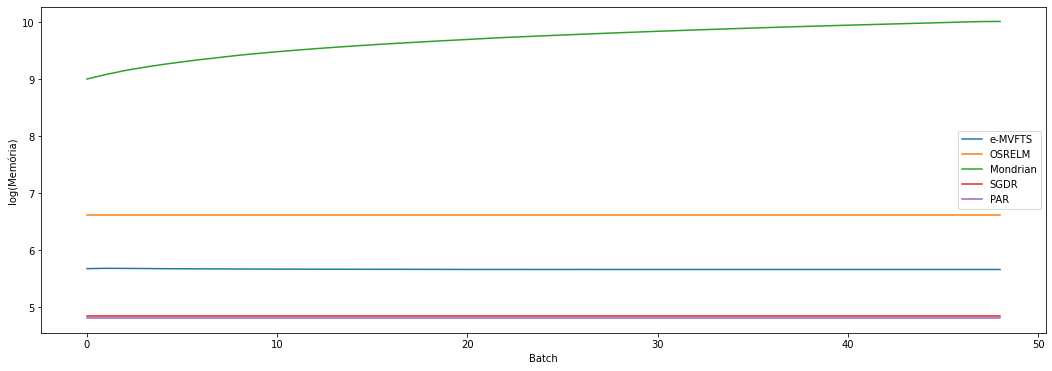

In [9]:
metric = "log(Memória)"
data = pd.DataFrame(columns=["e-MVFTS", "OSRELM", "MF", "SGDR", "PAR"])

data['e-MVFTS'] = np.log10(m1_emv)
data['OSRELM'] = np.log10(m1_osr)
data['MF'] = np.log10(m1_mf)
data['SGDR'] = np.log10(m1_sgdr)
data['PAR'] = np.log10(m1_par)

ax = data.plot(figsize=(18,6))
ax.set(xlabel='Batch', ylabel=metric)
fig = ax.get_figure()
# plt.legend(loc='lower left')
#fig.savefig(path_images + exp_id + "_prequential.png")
plt.savefig('log_memoria_solar.svg')

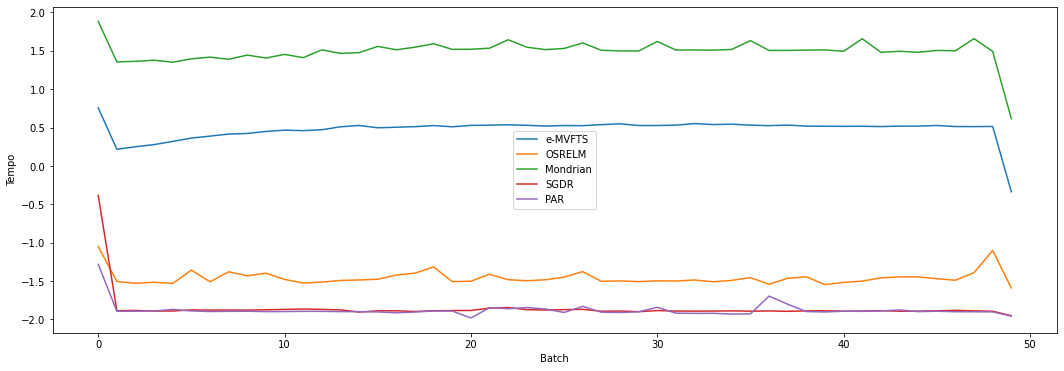

In [11]:
metric = "Tempo"
data = pd.DataFrame(columns=["e-MVFTS", "OSRELM", "MF", "SGDR", "PAR"])

data['e-MVFTS'] = np.log10(t1_emv)
data['OSRELM'] = np.log10(t1_osr)
data['MF'] = np.log10(t1_mf)
data['SGDR'] = np.log10(t1_sgdr)
data['PAR'] = np.log10(t1_par)

ax = data.plot(figsize=(18,6))
ax.set(xlabel='Batch', ylabel=metric)
fig = ax.get_figure()
# plt.legend(loc='lower left')
#fig.savefig(path_images + exp_id + "_prequential.png")
plt.savefig('log_tempo_solar.svg')

# Métricas

In [3]:
numRuns = len(forecasts_emvfts_runs)

# Remove o último elemento (para manter o formato dos vetores). 
# O emvfts prediz uma amostra além que as técnicas 
# Essa adequação também era feita no código original do artigo de energias renováveis

# Obs: Ao gerar os resultados, foi feita uma "gambiarra" para não executar a técnica 10x
# Não é necessário repetir pois ela é determinística, então o que foi feito foi replicar 
# os resultados. Mas o python replicou referencias aos resultados. Então alterar o objeto
# da primeira execução signifira alterar todas elas


# for i in range(0,numRuns):
numBatches = len(forecasts_emvfts_runs[0])
for j in range(0,numBatches):
    forecasts_emvfts_runs[0][j] = forecasts_emvfts_runs[0][j][:-1,:]
  


In [4]:
from pyFTS.benchmarks import Measures

rmse_emvfts = np.zeros((numRuns,numBatches))
rmse_osrelm = np.zeros((numRuns,numBatches))
rmse_mondrian = np.zeros((numRuns,numBatches))
rmse_sgdr = np.zeros((numRuns,numBatches))
rmse_par = np.zeros((numRuns,numBatches))

smape_emvfts = np.zeros((numRuns,numBatches))
smape_osrelm = np.zeros((numRuns,numBatches))
smape_mondrian = np.zeros((numRuns,numBatches))
smape_sgdr = np.zeros((numRuns,numBatches))
smape_par = np.zeros((numRuns,numBatches))

for i in range(0,numRuns):
    numBatches = len(forecasts_emvfts_runs[i])
    for j in range(0,numBatches):
        # j+1 pois o primeiro é o batch inicial, que não entra nos testes
        rmse_emvfts[i][j] = Measures.rmse(batches[j+1][_order:],forecasts_emvfts_runs[i][j])
        rmse_mondrian[i][j] = Measures.rmse(batches[j+1][_order:],forecasts_mondrian_runs[i][j])
        rmse_osrelm[i][j] = Measures.rmse(batches[j+1][_order:],forecasts_osrelm_runs[i][j])
        rmse_sgdr[i][j] = Measures.rmse(batches[j+1][_order:],forecasts_sgdr_runs[i][j])
        rmse_par[i][j] = Measures.rmse(batches[j+1][_order:],forecasts_par_runs[i][j])
        
        smape_emvfts[i][j] = Measures.smape(batches[j+1][_order:],forecasts_emvfts_runs[i][j])
        smape_mondrian[i][j] = Measures.smape(batches[j+1][_order:],forecasts_mondrian_runs[i][j])
        smape_osrelm[i][j] = Measures.smape(batches[j+1][_order:],forecasts_osrelm_runs[i][j])
        smape_sgdr[i][j] = Measures.smape(batches[j+1][_order:],forecasts_sgdr_runs[i][j])
        smape_par[i][j] = Measures.smape(batches[j+1][_order:],forecasts_par_runs[i][j])
        
        
rmse_emvfts_runs = np.mean(rmse_emvfts,axis=1)
rmse_osrelm_runs = np.mean(rmse_osrelm,axis=1)
rmse_mondrian_runs = np.mean(rmse_mondrian,axis=1)
rmse_sgdr_runs = np.mean(rmse_sgdr,axis=1)
rmse_par_runs = np.mean(rmse_par,axis=1)
      
rmse_emvfts_batches = np.mean(rmse_emvfts,axis=0)
rmse_osrelm_batches = np.mean(rmse_osrelm,axis=0)
rmse_mondrian_batches = np.mean(rmse_mondrian,axis=0)
rmse_sgdr_batches = np.mean(rmse_sgdr,axis=0)
rmse_par_batches = np.mean(rmse_par,axis=0)

smape_emvfts_runs = np.mean(smape_emvfts,axis=1)
smape_osrelm_runs = np.mean(smape_osrelm,axis=1)
smape_mondrian_runs = np.mean(smape_mondrian,axis=1)
smape_sgdr_runs = np.mean(smape_sgdr,axis=1)
smape_par_runs = np.mean(smape_par,axis=1)
      
smape_emvfts_batches = np.mean(smape_emvfts,axis=0)
smape_osrelm_batches = np.mean(smape_osrelm,axis=0)
smape_mondrian_batches = np.mean(smape_mondrian,axis=0)
smape_sgdr_batches = np.mean(smape_sgdr,axis=0)
smape_par_batches = np.mean(smape_par,axis=0)

# Gráfico

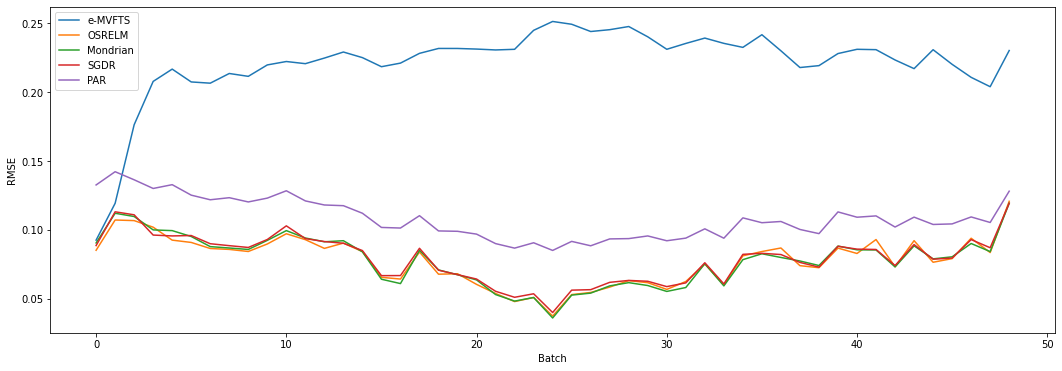

In [5]:
metric = "RMSE"
data = pd.DataFrame(columns=["e-MVFTS", "OSRELM", "Mondrian", "SGDR", "PAR"])

data['e-MVFTS'] = rmse_emvfts_batches
data['OSRELM'] = rmse_osrelm_batches
data['Mondrian'] = rmse_mondrian_batches
data['SGDR'] = rmse_sgdr_batches
data['PAR'] = rmse_par_batches

ax = data.plot(figsize=(18,6))
ax.set(xlabel='Batch', ylabel=metric)
fig = ax.get_figure()
# plt.legend(loc='lower left')
#fig.savefig(path_images + exp_id + "_prequential.png")
plt.savefig('solar_rmse_grafico.svg')
    
# x = np.arange(len(data.columns.values))
# names = data.columns.values
# values = data.mean().values
# plt.figure(figsize=(5,6))
# plt.bar(x, values, align='center', alpha=0.5, width=0.9)
# plt.xticks(x, names)
# #plt.yticks(np.arange(0, 1.1, 0.1))
# plt.ylabel(metric)
# #plt.savefig(path_images + exp_id + "_bars.png")

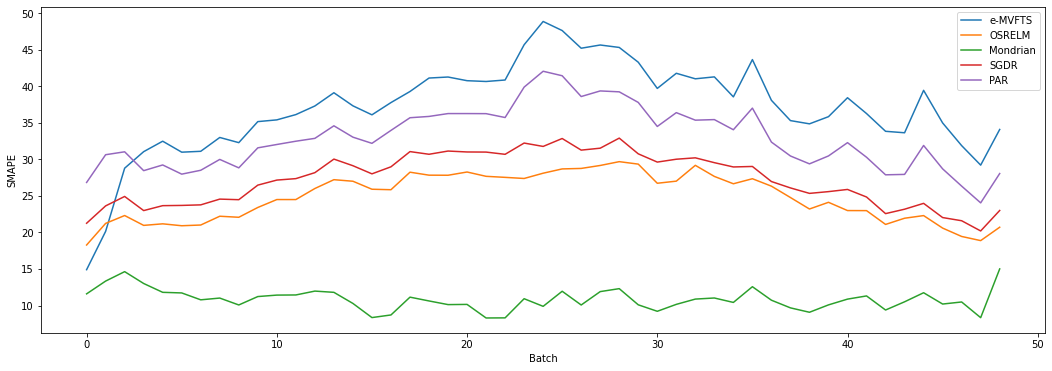

In [6]:
metric = "SMAPE"
data = pd.DataFrame(columns=["e-MVFTS", "OSRELM", "Mondrian", "SGDR", "PAR"])

data['e-MVFTS'] = smape_emvfts_batches
data['OSRELM'] = smape_osrelm_batches
data['Mondrian'] = smape_mondrian_batches
data['SGDR'] = smape_sgdr_batches
data['PAR'] = smape_par_batches

ax = data.plot(figsize=(18,6))
ax.set(xlabel='Batch', ylabel=metric)
fig = ax.get_figure()
#fig.savefig(path_images + exp_id + "_prequential.png")
plt.savefig('solar_smape_grafico.svg')
    
# x = np.arange(len(data.columns.values))
# names = data.columns.values
# values = data.mean().values
# plt.figure(figsize=(5,6))
# plt.bar(x, values, align='center', alpha=0.5, width=0.9)
# plt.xticks(x, names)
# #plt.yticks(np.arange(0, 1.1, 0.1))
# plt.ylabel(metric)
# #plt.savefig(path_images + exp_id + "_bars.png")

# Tabelas

In [7]:
metric = 'Tempo Gasto (s)'

t_emv = np.mean(tempo_emvfts_runs)
t_osr = np.mean(tempo_osrelm_runs)
t_mon = np.mean(tempo_mondrian_runs)
t_sgdr = np.mean(tempo_sgdr_runs)
t_par = np.mean(tempo_par_runs)

time_df = pd.DataFrame([t_emv,t_osr,t_mon,t_sgdr,t_par],index=["e-MVFTS", "OSRELM", "Mondrian", "SGDR", "PAR"],columns=[metric])

In [8]:
rmse_medio = []
rmse_medio.append(np.mean(rmse_emvfts_runs))
rmse_medio.append(np.mean(rmse_osrelm_runs))
rmse_medio.append(np.mean(rmse_mondrian_runs))
rmse_medio.append(np.mean(rmse_sgdr_runs))
rmse_medio.append(np.mean(rmse_par_runs))

In [9]:
rmse_std = []
rmse_std.append(np.std(rmse_emvfts_runs))
rmse_std.append(np.std(rmse_osrelm_runs))
rmse_std.append(np.std(rmse_mondrian_runs))
rmse_std.append(np.std(rmse_sgdr_runs))
rmse_std.append(np.std(rmse_par_runs))

In [10]:
smape_medio = []
smape_medio.append(np.mean(smape_emvfts_runs))
smape_medio.append(np.mean(smape_osrelm_runs))
smape_medio.append(np.mean(smape_mondrian_runs))
smape_medio.append(np.mean(smape_sgdr_runs))
smape_medio.append(np.mean(smape_par_runs))

In [11]:
smape_std = []
smape_std.append(np.std(smape_emvfts_runs))
smape_std.append(np.std(smape_osrelm_runs))
smape_std.append(np.std(smape_mondrian_runs))
smape_std.append(np.std(smape_sgdr_runs))
smape_std.append(np.std(smape_par_runs))

In [12]:
memoria_media = []
memoria_media.append(np.mean(memoria_emvfts_runs)/1024.0)
memoria_media.append(np.mean(memoria_osrelm_runs)/1024.0)
memoria_media.append(np.mean(memoria_mondrian_runs)/1024.0)
memoria_media.append(np.mean(memoria_sgdr_runs)/1024.0)
memoria_media.append(np.mean(memoria_par_runs)/1024.0)

In [13]:
time_df.insert(0,'RMSE_medio',rmse_medio)
time_df.insert(1,'RMSE_std',rmse_std)
time_df.insert(2,'SMAPE_medio',smape_medio)
time_df.insert(3,'SMAPE_std',smape_std)
time_df.insert(5,'Uso de Memória (kB)',memoria_media)

In [14]:
pd.options.display.float_format = '{:.4f}'.format
time_df.to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &  RMSE\\_medio &  RMSE\\_std &  SMAPE\\_medio &  SMAPE\\_std &  Tempo Gasto (s) &  Uso de Memória (kB) \\\\\n\\midrule\ne-MVFTS  &      0.2213 &    0.0000 &      37.0500 &     0.0000 &         157.2626 &             452.7578 \\\\\nOSRELM   &      0.0778 &    0.0001 &      24.8267 &     0.1551 &           3.0082 &            4098.9062 \\\\\nMondrian &      0.0781 &    0.0001 &      10.8280 &     0.0113 &        2698.4556 &        10116761.1422 \\\\\nSGDR     &      0.0793 &    0.0000 &      27.2489 &     0.0750 &           0.8410 &              68.8750 \\\\\nPAR      &      0.1082 &    0.0011 &      32.8710 &     0.1399 &          30.1083 &              62.9531 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [18]:
time_df

,RMSE_medio,RMSE_std,SMAPE_medio,SMAPE_std,Tempo Gasto (s),Uso de Memória (kB)
e-MVFTS,0.2213,0.0000,37.0500,0.0000,157.2626,452.7578
OSRELM,0.0778,0.0001,24.8267,0.1551,3.0082,4098.9062
Mondrian,0.0781,0.0001,10.8280,0.0113,2698.4556,10116761.1422
SGDR,0.0793,0.0000,27.2489,0.0750,0.8410,68.8750
PAR,0.1082,0.0011,32.8710,0.1399,30.1083,62.9531


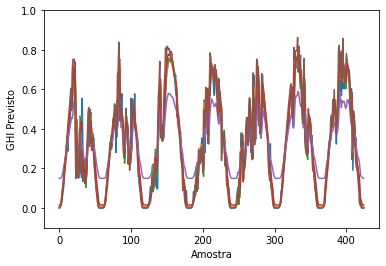

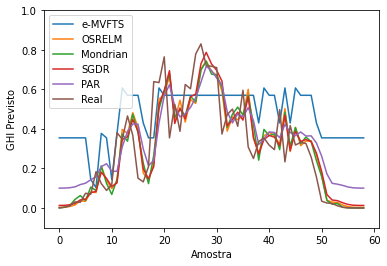

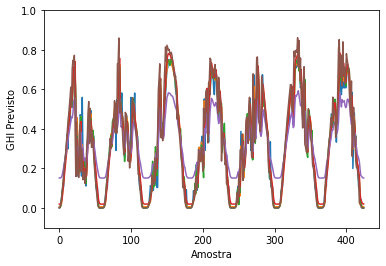

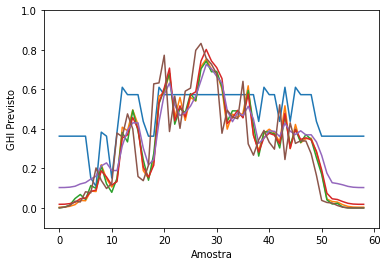

In [41]:
df1 = pd.DataFrame(columns=["e-MVFTS", "OSRELM", "Mondrian", "SGDR", "PAR", "Real"])
df2 = pd.DataFrame(columns=["e-MVFTS", "OSRELM", "Mondrian", "SGDR", "PAR", "Real"])
df3 = pd.DataFrame(columns=["e-MVFTS", "OSRELM", "Mondrian", "SGDR", "PAR", "Real"])
df4 = pd.DataFrame(columns=["e-MVFTS", "OSRELM", "Mondrian", "SGDR", "PAR", "Real"])

prim = []
ult = []

tmp = forecasts_emvfts_runs

for i in range(0,len(tmp)):
    prim.append(tmp[i][0])
    ult.append(tmp[i][-1])

prim = sum(prim)/len(prim)
ult = sum(ult)/len(ult)

df1['e-MVFTS'] = prim[:,0]
df2['e-MVFTS'] = ult[:,0]
df3['e-MVFTS'] = prim[:,1]
df4['e-MVFTS'] = ult[:,1]

##

prim = []
ult = []

tmp = forecasts_osrelm_runs

for i in range(0,len(tmp)):
    prim.append(tmp[i][0])
    ult.append(tmp[i][-1])

prim = sum(prim)/len(prim)
ult = sum(ult)/len(ult)

df1['OSRELM'] = prim[:,0]
df2['OSRELM'] = ult[:,0]
df3['OSRELM'] = prim[:,1]
df4['OSRELM'] = ult[:,1]

##

prim = []
ult = []

tmp = forecasts_mondrian_runs

for i in range(0,len(tmp)):
    prim.append(tmp[i][0])
    ult.append(tmp[i][-1])

prim = sum(prim)/len(prim)
ult = sum(ult)/len(ult)

df1['Mondrian'] = prim[:,0]
df2['Mondrian'] = ult[:,0]
df3['Mondrian'] = prim[:,1]
df4['Mondrian'] = ult[:,1]

##
prim = []
ult = []

tmp = forecasts_sgdr_runs

for i in range(0,len(tmp)):
    prim.append(tmp[i][0])
    ult.append(tmp[i][-1])

prim = sum(prim)/len(prim)
ult = sum(ult)/len(ult)

df1['SGDR'] = prim[:,0]
df2['SGDR'] = ult[:,0]
df3['SGDR'] = prim[:,1]
df4['SGDR'] = ult[:,1]

##
prim = []
ult = []

tmp = forecasts_par_runs

for i in range(0,len(tmp)):
    prim.append(tmp[i][0])
    ult.append(tmp[i][-1])

prim = sum(prim)/len(prim)
ult = sum(ult)/len(ult)

df1['PAR'] = prim[:,0]
df2['PAR'] = ult[:,0]
df3['PAR'] = prim[:,1]
df4['PAR'] = ult[:,1]


_,aux = batches_supervised[1]
df1['Real'] = aux[:,0]
_,aux = batches_supervised[-1]
df2['Real'] = aux[:,0]
_,aux = batches_supervised[1]
df3['Real'] = aux[:,1]
_,aux = batches_supervised[-1]
df4['Real'] = aux[:,1]


# df1['e-MVFTS'] = prim[:,0]
# data['OSRELM'] = rmse_osrelm_batches
# data['Mondrian'] = rmse_mondrian_batches
# data['SGDR'] = rmse_sgdr_batches
# data['PAR'] = rmse_par_batches

# df2 = pd.DataFrame(columns=["e-MVFTS", "OSRELM", "Mondrian", "SGDR", "PAR"])

# df2['e-MVFTS'] = ult[:,1]
# data['OSRELM'] = rmse_osrelm_batches
# data['Mondrian'] = rmse_mondrian_batches
# data['SGDR'] = rmse_sgdr_batches
# data['PAR'] = rmse_par_batches

# fig,axs = plt.figure(figsize=(18,6))
# fig,axs = plt.subplots(2,2,figsize=(18,6))
# df1.plot(ax=axs[0,0],legend=False)
# df2.plot(ax=axs[0,1],legend=False)
# df3.plot(ax=axs[1,0],legend=False)
# df4.plot(ax=axs[1,1],legend=True)
# plt.subplot(2,2,1)
# plt.plot(prim[:,0])
# plt.subplot(2,2,2)
# plt.plot(ult[:,0])
# plt.subplot(2,2,3)
# plt.plot(prim[:,1])
# plt.subplot(2,2,4)
# plt.plot(ult[:,1])
# plt.show()
# plt.savefig('predicao.svg')


df1.plot(legend=False)
plt.ylim(0-0.1,1)
plt.xlabel('Amostra')
plt.ylabel('GHI Previsto')
plt.savefig('predicao1.svg')
df2.plot()
plt.ylim(0-0.1,1)
plt.xlabel('Amostra')
plt.ylabel('GHI Previsto')
plt.savefig('predicao2.svg')
df3.plot(legend=False)
plt.ylim(0-0.1,1)
plt.xlabel('Amostra')
plt.ylabel('GHI Previsto')
plt.savefig('predicao3.svg')
df4.plot(legend=False)
plt.ylim(0-0.1,1)
plt.xlabel('Amostra')
plt.ylabel('GHI Previsto')
plt.savefig('predicao4.svg')

In [16]:
# plt.figure()
# plt.plot(forecasts_sgdr_runs[0][-1][1])
# plt.show()
# # print(forecasts_sgdr_runs[0][5].shape)

In [30]:
a,b = batches_supervised[1]
b[]

(425, 16)